flagging the abnormal values

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode

df = pd.read_excel("Données financières.xlsx")
df_sorted = df.sort_values(by=["ID-ENT", "ANNEE_N"]).copy()
df_sorted["flag"] = 0

LOWER_RATIO = 1 / 1000
UPPER_RATIO = 1000
 
for company_id, group in df_sorted.groupby("ID-ENT"):
    group = group.sort_values("ANNEE_N")
    k_values = group["K_social"].values
    indices = group.index.values

    # Pass 1: Year-to-year comparison
    for i in range(len(k_values)):
        current_k = k_values[i]

        if pd.isna(current_k) or current_k == 0:
            continue

        if i > 0:
            prev_k = k_values[i - 1]
            if pd.isna(prev_k) or prev_k == 0:
                continue

            ratio = max(current_k / prev_k, prev_k / current_k)
            if ratio < LOWER_RATIO or ratio > UPPER_RATIO:
                df_sorted.loc[[indices[i], indices[i - 1]], "flag"] = 1

        elif i == 0 and len(k_values) > 1:
            next_k = k_values[i + 1]
            if pd.isna(next_k) or next_k == 0:
                continue

            ratio = max(current_k / next_k, next_k / current_k)
            if ratio < LOWER_RATIO or ratio > UPPER_RATIO:
                df_sorted.loc[[indices[i], indices[i + 1]], "flag"] = 1

    # Pass 2: Compare each value to mode of non-zero values
    valid_values = [v for v in k_values if pd.notna(v) and v != 0]
    if len(valid_values) >= 2:
        mode_k = mode(valid_values, keepdims=False).mode
        if isinstance(mode_k, np.ndarray):
            mode_k = mode_k[0]

        for i in range(len(k_values)):
            current_k = k_values[i]
            if pd.isna(current_k) or current_k == 0:
                continue

            ratio_to_mode = max(current_k / mode_k, mode_k / current_k)
            if ratio_to_mode > UPPER_RATIO:
                df_sorted.loc[indices[i], "flag"] = 1

df_result = df_sorted[["ID-ENT", "ANNEE_N", "K_social", "flag"]]
df_result.to_excel("K_social_flags.xlsx", index=False)
print("✅ Done! Output saved to K_social_flags.xlsx")


✅ Done! Output saved to K_social_flags.xlsx


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import mode


df = pd.read_excel("K_social_flags.xlsx")


RATIO_THRESHOLD = 10  # Adjust as needed


for company_id, group in df.groupby("ID-ENT"):
    k_values = group["K_social"].values
    flags = group["flag"].values
    indices = group.index.values

    # Find mode ignoring zeros and NaNs
    valid_values = [v for v in k_values if pd.notna(v) and v != 0]
    if len(valid_values) < 2:
        continue 

    mode_val = mode(valid_values, keepdims=False).mode
    if isinstance(mode_val, np.ndarray):
        mode_val = mode_val[0]

    for i, (val, flag) in enumerate(zip(k_values, flags)):
        if flag == 1 and pd.notna(val) and val != 0:
            ratio_to_mode = max(val / mode_val, mode_val / val)
            if ratio_to_mode < RATIO_THRESHOLD:
                df.loc[indices[i], "flag"] = 0

# Save updated flags (no value changes) to new file
df.to_excel("K_social_flags_refined.xlsx", index=False)
print("✅ Done! Refined flags saved to K_social_flags_refined.xlsx")


✅ Done! Refined flags saved to K_social_flags_refined.xlsx


In [3]:
import pandas as pd

# Load original data
df_original = pd.read_excel("Données financières.xlsx")

# Load refined flags
df_flags = pd.read_excel("K_social_flags_refined.xlsx")

# Merge on 'ID-ENT' and 'ANNEE_N'
df_flagged = pd.merge(
    df_original,
    df_flags[['ID-ENT', 'ANNEE_N', 'flag']],  # only keep flag columns for merge
    on=['ID-ENT', 'ANNEE_N'],
    how='left'  # keep all original rows, fill flag if available
)

# If there are any missing flags, fill them with 0 (assuming unflagged)
df_flagged['flag'] = df_flagged['flag'].fillna(0).astype(int)

# Save to new Excel file
df_flagged.to_excel("Données_financières_flagged.xlsx", index=False)

print("✅ Merged data with refined flags saved to Données_financières_flagged.xlsx")

✅ Merged data with refined flags saved to Données_financières_flagged.xlsx


pearson

In [4]:
import pandas as pd

file_path = "Données_financières_flagged.xlsx"
df = pd.read_excel(file_path)
flag_col = 'flag'
numeric_cols = df.select_dtypes(include='number').columns.tolist()
vars_for_corr = [col for col in numeric_cols if col != flag_col]
df_filtered = df[df[flag_col] == 0]

# Pearson Correlation
def compute_and_save_pearson(df_subset, label):
    df_vars = df_subset[vars_for_corr]
    pearson_corr = df_vars.corr(method='pearson')
    pearson_corr.to_excel(f"correlation_{label}_pearson.xlsx")

compute_and_save_pearson(df_filtered, 'filtered')
compute_and_save_pearson(df, 'full')


Spearman 

In [5]:
# Spearman Correlation
def compute_and_save_spearman(df_subset, label):
    df_vars = df_subset[vars_for_corr]
    spearman_corr = df_vars.corr(method='spearman')
    spearman_corr.to_excel(f"correlation_{label}_spearman.xlsx")

compute_and_save_spearman(df_filtered, 'filtered')
compute_and_save_spearman(df, 'full')


 Kendall

In [6]:
# Kendall Correlation (with optional sampling)
def compute_and_save_kendall(df_subset, label, sample_size=None):
    df_vars = df_subset[vars_for_corr]
    if sample_size:
        df_vars = df_vars.sample(n=sample_size, random_state=42)
    
    kendall_corr = df_vars.corr(method='kendall')
    kendall_corr.to_excel(f"correlation_{label}_kendall.xlsx")

# Try full data first. If too slow, uncomment sample_size.
compute_and_save_kendall(df_filtered, 'filtered', sample_size=5000)  
compute_and_save_kendall(df, 'full', sample_size=5000)


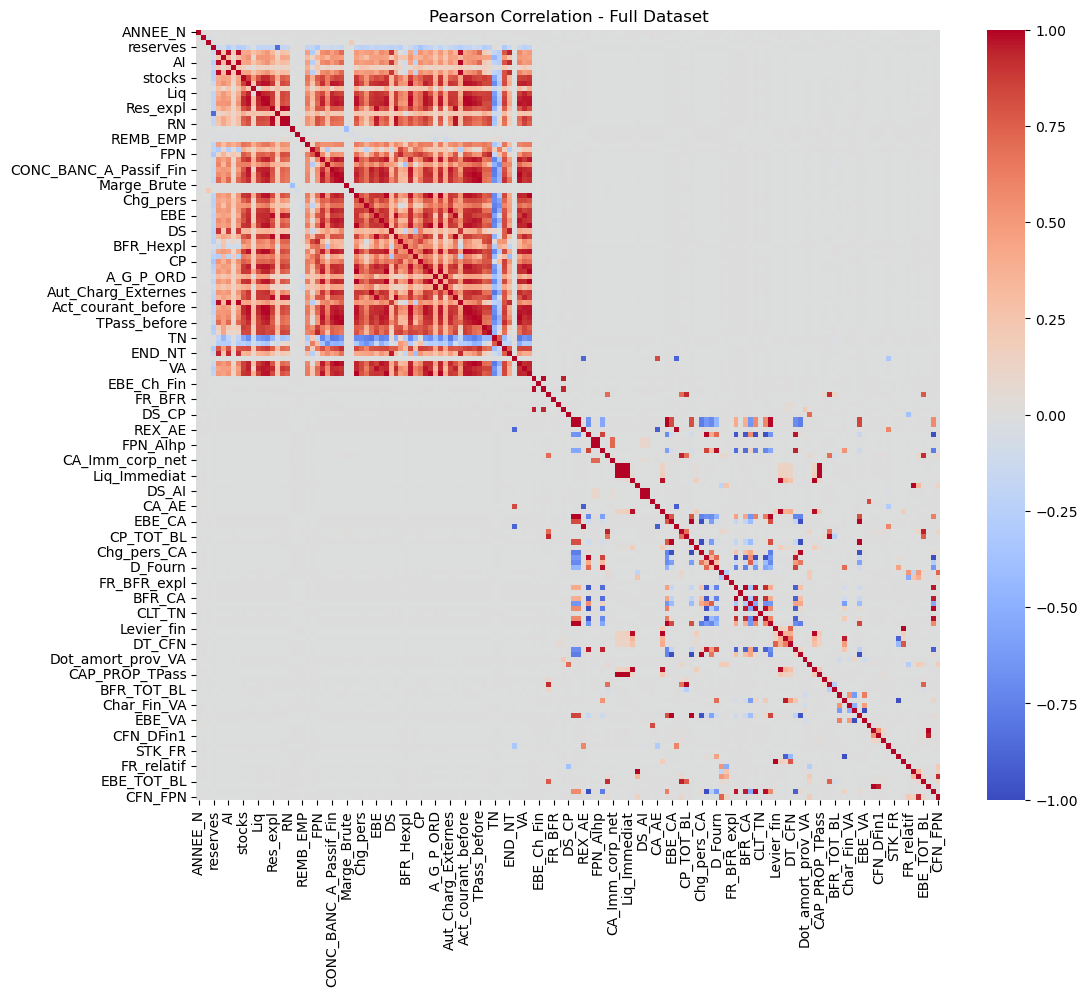

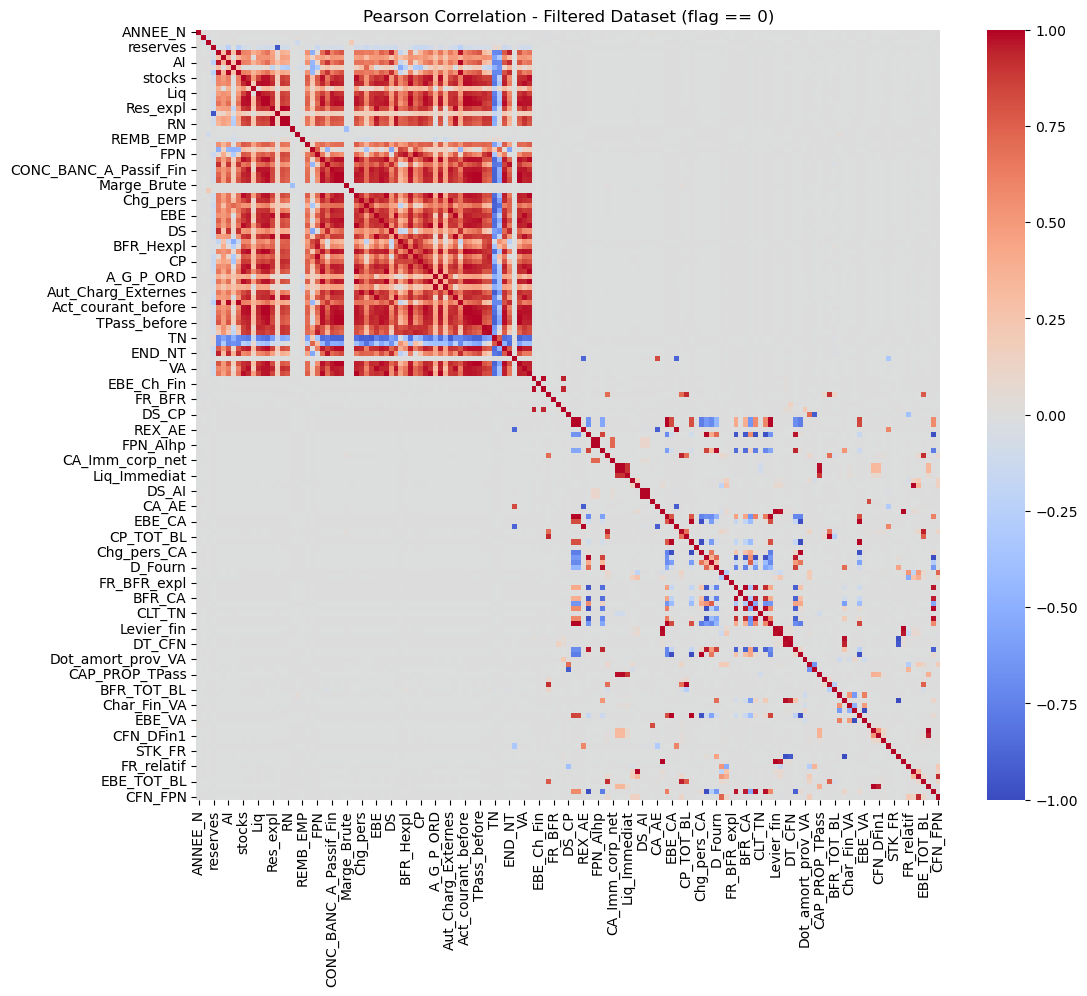

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load correlations
corr_full = pd.read_excel('correlation_full_pearson.xlsx', index_col=0)
corr_filtered = pd.read_excel('correlation_filtered_pearson.xlsx', index_col=0)

# Plot Full
plt.figure(figsize=(12, 10))
sns.heatmap(corr_full, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
plt.title('Pearson Correlation - Full Dataset')
plt.show()

# Plot Filtered
plt.figure(figsize=(12, 10))
sns.heatmap(corr_filtered, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
plt.title('Pearson Correlation - Filtered Dataset (flag == 0)')
plt.show()


In [8]:
## Calculate absolute difference matrix
diff_matrix = (corr_full - corr_filtered).abs()

# Show biggest differences
diff_matrix = diff_matrix.stack().reset_index()
diff_matrix.columns = ['Variable 1', 'Variable 2', 'Difference']
diff_matrix = diff_matrix.sort_values(by='Difference', ascending=False)

# See top 10 biggest differences
print(diff_matrix.head(10))


        Variable 1   Variable 2  Difference
18963  CAP_PROP_CP     Part_FPN    1.054634
13413     Part_FPN  CAP_PROP_CP    1.054634
17943       DT_FPN  CAP_PROP_CP    0.986335
18993  CAP_PROP_CP       DT_FPN    0.986335
18969  CAP_PROP_CP       AE_FPN    0.982734
14319       AE_FPN  CAP_PROP_CP    0.982734
14282       AE_FPN     Part_FPN    0.956640
13382     Part_FPN       AE_FPN    0.956640
17906       DT_FPN     Part_FPN    0.950336
13406     Part_FPN       DT_FPN    0.950336


In [9]:
total_change = diff_matrix['Difference'].mean()
print(f"Average correlation difference after filtering: {total_change:.4f}")


Average correlation difference after filtering: 0.0159


The filtering process (removing flagged rows) led to notable correlation changes in some variable pairs, particularly involving CAP_PROP_CP, Part_FPN, and DT_FPN. However, the overall average correlation difference is approximately 0.016, suggesting that for most variables, the underlying relationships remained stable. This indicates that while filtering was necessary to clean specific anomalies, the core structure of the data is largely preserved

In [10]:
import pandas as pd

# Load correlation matrices
corr_full = pd.read_excel('correlation_full_spearman.xlsx', index_col=0)
corr_filtered = pd.read_excel('correlation_filtered_spearman.xlsx', index_col=0)

# Calculate absolute differences
diff_matrix = (corr_full - corr_filtered).abs()

# Turn matrix into long dataframe
diff_long = diff_matrix.stack().reset_index()
diff_long.columns = ['Variable 1', 'Variable 2', 'Difference']

# Remove self-correlations (diagonal)
diff_long = diff_long[diff_long['Variable 1'] != diff_long['Variable 2']]

# Create a sorted tuple of variable pairs to identify duplicates like (A,B) and (B,A)
diff_long['pair'] = diff_long.apply(lambda row: tuple(sorted([row['Variable 1'], row['Variable 2']])), axis=1)

# Drop duplicates based on the pair (keeping first occurrence)
diff_long_unique = diff_long.drop_duplicates(subset=['pair']).copy()

# Sort by Difference descending to find biggest changes
diff_long_unique = diff_long_unique.sort_values(by='Difference', ascending=False).reset_index(drop=True)

# Save the cleaned difference matrix
diff_long_unique.to_excel("spearman_correlation_difference_cleaned.xlsx", index=False)

# Print top 10 biggest differences
print(diff_long_unique.head(10))

# Calculate and print average difference
total_change = diff_long_unique['Difference'].mean()
print(f"Average correlation difference after filtering (Spearman): {total_change:.4f}")


            Variable 1       Variable 2  Difference  \
0       Dot_amort_prov  CA_Imm_corp_net    0.002437   
1         Imm_corp_net  CA_Imm_corp_net    0.002302   
2                  Liq         A_PASS_C    0.002151   
3                ImNet  CA_Imm_corp_net    0.002046   
4          ACTIF_IMMOB  CA_Imm_corp_net    0.002045   
5                   AI  CA_Imm_corp_net    0.002045   
6         TPass_before           FPN_AE    0.002041   
7  Pass_courant_before    FR_TOT_BL_hAI    0.002017   
8         TPass_before        FR_TOT_BL    0.002011   
9       Dot_amort_prov            CA_AE    0.002009   

                                   pair  
0     (CA_Imm_corp_net, Dot_amort_prov)  
1       (CA_Imm_corp_net, Imm_corp_net)  
2                       (A_PASS_C, Liq)  
3              (CA_Imm_corp_net, ImNet)  
4        (ACTIF_IMMOB, CA_Imm_corp_net)  
5                 (AI, CA_Imm_corp_net)  
6                (FPN_AE, TPass_before)  
7  (FR_TOT_BL_hAI, Pass_courant_before)  
8             (F

In [11]:
significant_diff = diff_long_unique[diff_long_unique['Difference'] > 0.01]
print("Pairs with >0.01 difference:\n", significant_diff)


Pairs with >0.01 difference:
 Empty DataFrame
Columns: [Variable 1, Variable 2, Difference, pair]
Index: []


The filtering applied to exclude flagged rows has a small but noticeable impact on Pearson correlations, indicating it helps remove linear relationship noise possibly due to outliers or errors.
However, the Spearman correlations — which measure monotonic relationships and are more robust to outliers — show almost no difference after filtering. This suggests the overall data structure and variable ranking are preserved even without filtering.
Therefore, filtering is beneficial for analyses sensitive to outliers or precise linear relationships but may be less critical if using rank-based methods.

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau

# Load the file
file_path = "Données_financières_flagged.xlsx"
df = pd.read_excel(file_path)

# Set the flag column and select numeric columns excluding the flag
flag_col = 'flag'
numeric_cols = df.select_dtypes(include='number').columns.tolist()
vars_for_corr = [col for col in numeric_cols if col != flag_col]

print("Data loaded and variables prepared.")


Data loaded and variables prepared.


In [13]:
from tqdm import tqdm  # Progress bar for the win
# Prepare results list
results = []

# Loop with progress bar
for i in tqdm(range(len(vars_for_corr)), desc="Calculating Correlations..."):
    for j in range(i + 1, len(vars_for_corr)):
        var1 = vars_for_corr[i]
        var2 = vars_for_corr[j]

        # Full dataset
        x_full = df[var1]
        y_full = df[var2]

        # Create mask to remove NaN and Inf together
        mask_full = np.isfinite(x_full) & np.isfinite(y_full)

        x_full_clean = x_full[mask_full]
        y_full_clean = y_full[mask_full]

        # Filtered dataset
        df_filtered = df[df[flag_col] == 0]
        x_filtered = df_filtered[var1]
        y_filtered = df_filtered[var2]

        mask_filtered = np.isfinite(x_filtered) & np.isfinite(y_filtered)

        x_filtered_clean = x_filtered[mask_filtered]
        y_filtered_clean = y_filtered[mask_filtered]

        # Calculate Pearson
        if len(x_full_clean) > 1 and len(x_filtered_clean) > 1:
            pearson_full, pval_pearson_full = pearsonr(x_full_clean, y_full_clean)
            pearson_filtered, pval_pearson_filtered = pearsonr(x_filtered_clean, y_filtered_clean)
        else:
            pearson_full, pval_pearson_full = (None, None)
            pearson_filtered, pval_pearson_filtered = (None, None)

        # Calculate Spearman
        if len(x_full_clean) > 1 and len(x_filtered_clean) > 1:
            spearman_full, pval_spearman_full = spearmanr(x_full_clean, y_full_clean)
            spearman_filtered, pval_spearman_filtered = spearmanr(x_filtered_clean, y_filtered_clean)
        else:
            spearman_full, pval_spearman_full = (None, None)
            spearman_filtered, pval_spearman_filtered = (None, None)

        # Store results
        results.append({
            'Var1': var1,
            'Var2': var2,
            'Pearson_Full': pearson_full,
            'Pearson_Filtered': pearson_filtered,
            'P_Value_Pearson_Full': pval_pearson_full,
            'P_Value_Pearson_Filtered': pval_pearson_filtered,
            'Spearman_Full': spearman_full,
            'Spearman_Filtered': spearman_filtered,
            'P_Value_Spearman_Full': pval_spearman_full,
            'P_Value_Spearman_Filtered': pval_spearman_filtered
        })

    


Calculating Correlations...: 100%|███████████████████████████████████████████████████| 151/151 [36:02<00:00, 14.32s/it]


In [14]:
# Convert to DataFrame and save to Excel
results_df = pd.DataFrame(results)

output_file = "Correlation_Results.xlsx"
results_df.to_excel(output_file, index=False)

print(f"✅ Correlation results saved to {output_file} 🚀🔥")


✅ Correlation results saved to Correlation_Results.xlsx 🚀🔥


In [15]:
import pandas as pd

# Load your results file
results_file = "Correlation_Results.xlsx"
results_df = pd.read_excel(results_file)

# Prepare list to store interpretation
interpretations = []

for idx, row in results_df.iterrows():
    var1 = row['Var1']
    var2 = row['Var2']

    # Correlations and p-values
    pearson_full = row['Pearson_Full']
    pearson_filtered = row['Pearson_Filtered']
    pval_full = row['P_Value_Pearson_Full']
    pval_filtered = row['P_Value_Pearson_Filtered']

    # Default interpretation
    interpretation = "No clear improvement."

    # Check if filtering made it significant
    if pval_full > 0.05 and pval_filtered <= 0.05:
        interpretation = "✅ Filtering revealed a significant correlation (flagging was useful)."
    elif pval_full <= 0.05 and pval_filtered > 0.05:
        interpretation = "⚠️ Correlation lost significance after filtering (possible over-filtering)."
    elif pval_full <= 0.05 and pval_filtered <= 0.05:
        if abs(pearson_filtered) > abs(pearson_full):
            interpretation = "✅ Correlation remained significant and became stronger after filtering."
        else:
            interpretation = "⚠️ Correlation remained significant but got weaker after filtering."
    else:
        if abs(pearson_filtered) > abs(pearson_full):
            interpretation = "✅ No significance but the correlation strength improved after filtering."
        else:
            interpretation = "No significant change in correlation or significance."

    # Store interpretation
    interpretations.append(interpretation)

# Add interpretations to the DataFrame
results_df['Interpretation'] = interpretations

# Save to new Excel file
output_file = "Correlation_Results_Interpreted.xlsx"
results_df.to_excel(output_file, index=False)

print(f"✅ Full interpretation saved to {output_file}")


✅ Full interpretation saved to Correlation_Results_Interpreted.xlsx


In [16]:
import pandas as pd

# Load the interpreted results
results_df = pd.read_excel("Correlation_Results_Interpreted.xlsx")

# Counters
total_pairs = len(results_df)
improved_significance = 0
lost_significance = 0
improved_strength = 0
weakened_strength = 0

# For average calculations
total_full_corr = 0
total_filtered_corr = 0
total_full_pval = 0
total_filtered_pval = 0

for idx, row in results_df.iterrows():
    pearson_full = row['Pearson_Full']
    pearson_filtered = row['Pearson_Filtered']
    pval_full = row['P_Value_Pearson_Full']
    pval_filtered = row['P_Value_Pearson_Filtered']

    # Significance improvement
    if pval_full > 0.05 and pval_filtered <= 0.05:
        improved_significance += 1
    elif pval_full <= 0.05 and pval_filtered > 0.05:
        lost_significance += 1

    # Strength improvement
    if abs(pearson_filtered) > abs(pearson_full):
        improved_strength += 1
    else:
        weakened_strength += 1

    # Add for averages
    total_full_corr += abs(pearson_full)
    total_filtered_corr += abs(pearson_filtered)
    total_full_pval += pval_full
    total_filtered_pval += pval_filtered

# Calculate percentages
percent_improved = (improved_significance / total_pairs) * 100
percent_lost = (lost_significance / total_pairs) * 100
percent_strength_improved = (improved_strength / total_pairs) * 100

# Calculate averages
avg_full_corr = total_full_corr / total_pairs
avg_filtered_corr = total_filtered_corr / total_pairs
avg_full_pval = total_full_pval / total_pairs
avg_filtered_pval = total_filtered_pval / total_pairs

# Print summary
print("====== Global Filtering Evaluation ======")
print(f"✅ {percent_improved:.2f}% of correlations became significant after filtering.")
print(f"⚠️ {percent_lost:.2f}% of correlations lost significance after filtering.")
print(f"✅ {percent_strength_improved:.2f}% of correlations became stronger after filtering.")
print(f"📊 Average correlation strength (before filtering): {avg_full_corr:.4f}")
print(f"📊 Average correlation strength (after filtering): {avg_filtered_corr:.4f}")
print(f"📉 Average p-value (before filtering): {avg_full_pval:.4f}")
print(f"📉 Average p-value (after filtering): {avg_filtered_pval:.4f}")

# Final conclusion
if percent_improved > percent_lost and avg_filtered_corr > avg_full_corr and avg_filtered_pval < avg_full_pval:
    print("\n🏆 Conclusion: Filtering was globally beneficial. It improved statistical significance and correlation strength.")
else:
    print("\n⚡ Conclusion: Filtering had limited or mixed impact. Consider reviewing the flagging criteria.")


====== Global Filtering Evaluation ======
✅ 0.53% of correlations became significant after filtering.
⚠️ 0.85% of correlations lost significance after filtering.
✅ 47.62% of correlations became stronger after filtering.
📊 Average correlation strength (before filtering): 0.1037
📊 Average correlation strength (after filtering): 0.1127
📉 Average p-value (before filtering): 0.7437
📉 Average p-value (after filtering): 0.7476

⚡ Conclusion: Filtering had limited or mixed impact. Consider reviewing the flagging criteria.


In [17]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'Données_financières_flagged.xlsx'
df = pd.read_excel(file_path)

# Define key columns
sector_col = 'SECTEUR'
ca_col = 'CA'

# Your full variable list to check for outliers
variables = [
     'EXPORT', 'reserves', 'Imm_corp_net', 'Participations', 'AI', 'AACTNC',
    'ImNet', 'stocks', 'A_ACT_C', 'PLAC_A_ACTIF_FIN', 'Liq', 'Act_courant', 'Tot_Bl',
    'Res_expl', 'PROD_PLC', 'RAIP', 'RN', 'Elem_extra', 'div_distr', 'REMB_EMP', 'K_social',
    'RES_REPORTE', 'FPN', 'Fournisseurs', 'A_PASS_C', 'CONC_BANC_A_Passif_Fin', 'Pass_courant',
    'TPass', 'Marge_Brute', 'A_PROD_EXPL', 'Prod_expl', 'Chg_pers', 'Dot_amort_prov',
    'A_CHG_EXPL', 'EBE', 'Char_fin', 'CA', 'DS', 'CFN', 'FR', 'BFR_Hexpl', 'clients',
    'CAP_PROP', 'CP', 'Impots', 'ACH_CONS', 'A_G_P_ORD', 'Production', 'G_P_Ord',
    'Aut_Charg_Externes', 'CFN_S', 'ACTIF_IMMOB', 'Act_courant_before', 'Tot_Bl_before',
    'Pass_courant_before', 'TPass_before', 'BFR_expl', 'BFR', 'TN', 'TN_expl', 'AE',
    'END_NT', 'stocks_AE', 'DT', 'VA', 'CA_TTC'
]

# Create CA_GROUP based on your definitions
def assign_ca_group(ca_value):
    if ca_value < 500:
        return 'Small'
    elif 500 <= ca_value <= 10000:
        return 'Medium'
    else:
        return 'Large'

df['CA_GROUP'] = df[ca_col].apply(assign_ca_group)

# Tukey bounds function
def tukey_bounds(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return q1, q3, lower_bound, upper_bound

# Initialize a single outlier flag column
df['outlier'] = 0

# Loop through variables and detect/fix outliers grouped by sector and CA group
for var in variables:
    for (sector, ca_group), group_data in df.groupby([sector_col, 'CA_GROUP']):
        # Work only where flag == 0
        condition = (df[sector_col] == sector) & (df['CA_GROUP'] == ca_group) & (df['flag'] == 0)
        # If no valid data, skip
        if df.loc[condition, var].dropna().empty:
            continue

        # Get Tukey bounds
        q1, q3, lower_bound, upper_bound = tukey_bounds(df.loc[condition, var])

        # Detect outliers below lower bound
        outlier_low = condition & (df[var] < lower_bound)
        # Detect outliers above upper bound
        outlier_high = condition & (df[var] > upper_bound)

        # Flag any detected outlier
        df.loc[outlier_low | outlier_high, 'outlier'] = 1

        # Correct outlier values with Q1 or Q3
        df.loc[outlier_low, var] = q1
        df.loc[outlier_high, var] = q3

# Save the cleaned and flagged dataset
output_file = 'Données_financières_outliers_flagged_and_capped.xlsx'
df.to_excel(output_file, index=False)

print(f"✅ Outlier flagging and correction completed and saved to: {output_file}")


✅ Outlier flagging and correction completed and saved to: Données_financières_outliers_flagged_and_capped.xlsx


In [ ]:
import pandas as pd
import numpy as np

# --- Load the outlier-corrected dataset ---
df = pd.read_excel("Données_financières_outliers_flagged_and_capped.xlsx")

# --- Safe divide function ---
def safe_divide(a, b):
    return np.where(b == 0, np.where(a == 0, 0, np.nan), a / b)

# --- Recalculate all ratios ---

df['DS_CFN'] = safe_divide(df['DS'], df['CFN'])
df['DS_EBE'] = safe_divide(df['DS'], df['EBE'])
df['DS_CP'] = safe_divide(df['DS'], df['CP'])
df['RN_CA'] = safe_divide(df['RN'], df['CA'])
df['RAIP_CA'] = safe_divide(df['RAIP'], df['CA'])
df['REX_AE'] = safe_divide(df['Elem_extra'], df['AE'])
df['Ch_Fin_CA'] = safe_divide(df['Char_fin'], df['CA'])
df['CP_AI'] = safe_divide(df['CP'], df['AI'])
df['FPN_AIhp'] = safe_divide(df['FPN'], df['AI'])
df['AI_CA'] = safe_divide(df['AI'], df['CA'])
df['CA_TOT_BL'] = safe_divide(df['CA'], df['Tot_Bl'])
df['CA_Imm_corp_net'] = safe_divide(df['CA'], df['Imm_corp_net'])
df['Liq_Generale'] = safe_divide(df['Act_courant'], df['Pass_courant'])
df['Liq_Reduite'] = safe_divide(df['Act_courant'] - df['stocks'], df['Pass_courant'])
df['Liq_Immediat'] = safe_divide(df['Liq'], df['Pass_courant'])
df['Part_FPN'] = safe_divide(df['FPN'], df['Pass_courant'])
df['DS_FPN'] = safe_divide(df['DS'], df['FPN'])
df['DS_AI'] = safe_divide(df['DS'], df['AI'])
df['DS_AIhp'] = safe_divide(df['DS'], df['AI'])
df['FPN_DS'] = safe_divide(df['FPN'], df['DS'])
df['CA_AE'] = safe_divide(df['CA'], df['AE'])
df['AE_FPN'] = safe_divide(df['AE'], df['FPN'])
df['CFN_CA'] = safe_divide(df['CFN'], df['CA'])
df['EBE_CA'] = safe_divide(df['EBE'], df['CA'])
df['EBE_AE'] = safe_divide(df['EBE'], df['AE'])
df['ROA'] = safe_divide(df['RN'], df['ACTIF_IMMOB'])
df['CP_TOT_BL'] = safe_divide(df['CP'], df['Tot_Bl'])
df['REX_CA'] = safe_divide(df['Elem_extra'], df['CA'])
df['CAP_PROP_K_social'] = safe_divide(df['CAP_PROP'], df['K_social'])
df['Chg_pers_CA'] = safe_divide(df['Chg_pers'], df['CA'])
df['D_CLT'] = safe_divide(df['clients'], df['TN'])
df['D_STK'] = safe_divide(df['stocks'], df['TN'])
df['D_Fourn'] = safe_divide(df['Fournisseurs'], df['TN'])
df['ROE'] = safe_divide(df['RN'], df['K_social'])
df['CA_CAP_PROP'] = safe_divide(df['CA'], df['CAP_PROP'])
df['FR_BFR_expl'] = safe_divide(df['FR'], df['BFR_Hexpl'])
df['FR_CA'] = safe_divide(df['FR'], df['CA'])
df['FR_STK'] = safe_divide(df['FR'], df['stocks'])
df['BFR_CA'] = safe_divide(df['BFR'], df['CA'])
df['BFRE_CA'] = safe_divide(df['BFR_expl'], df['CA'])
df['TN_CA'] = safe_divide(df['TN'], df['CA'])
df['CLT_TN'] = safe_divide(df['clients'], df['TN'])
df['TN_expl_CA'] = safe_divide(df['TN_expl'], df['CA'])
df['RN_Prod_expl'] = safe_divide(df['RN'], df['Prod_expl'])
df['Levier_fin'] = safe_divide(df['Tot_Bl'], df['K_social'])
df['DT_FPN'] = safe_divide(df['DT'], df['FPN'])
df['DT_EBE'] = safe_divide(df['DT'], df['EBE'])
df['DT_CFN'] = safe_divide(df['DT'], df['CFN'])
df['DT_CA'] = safe_divide(df['DT'], df['CA'])
df['Dot_amort_prov_CA'] = safe_divide(df['Dot_amort_prov'], df['CA'])
df['Dot_amort_prov_VA'] = safe_divide(df['Dot_amort_prov'], df['VA'])
df['EBE_CP'] = safe_divide(df['EBE'], df['CP'])
df['CAP_PROP_CP'] = safe_divide(df['CAP_PROP'], df['CP'])
df['CAP_PROP_TPass'] = safe_divide(df['CAP_PROP'], df['TPass'])
df['FR_TOT_BL_hAI'] = safe_divide(df['FR'], df['Tot_Bl'] - df['AI'])
df['FR_TOT_BL'] = safe_divide(df['FR'], df['Tot_Bl'])
df['BFR_TOT_BL'] = safe_divide(df['BFR'], df['Tot_Bl'])
df['CFN_VA'] = safe_divide(df['CFN'], df['VA'])
df['AI_VA'] = safe_divide(df['AI'], df['VA'])
df['Char_Fin_VA'] = safe_divide(df['Char_fin'], df['VA'])
df['Chg_pers_VA'] = safe_divide(df['Chg_pers'], df['VA'])
df['VA_CA'] = safe_divide(df['VA'], df['CA'])
df['EBE_VA'] = safe_divide(df['EBE'], df['VA'])
df['EBE_DS'] = safe_divide(df['EBE'], df['DS'])
df['CFN_DT'] = safe_divide(df['CFN'], df['DT'])
df['CFN_DFin1'] = safe_divide(df['CFN'], df['D_CLT'] + df['D_Fourn'])
df['CFN_DFin2'] = safe_divide(df['CFN'], df['D_CLT'] + df['D_STK'])
df['FPN_AE'] = safe_divide(df['FPN'], df['AE'])
df['STK_FR'] = safe_divide(df['stocks'], df['FR'])
df['Fourn_ACH_CONS'] = safe_divide(df['Fournisseurs'], df['ACH_CONS'])
df['BFR_relatif'] = safe_divide(df['BFR'], df['Tot_Bl'])
df['FR_relatif'] = safe_divide(df['FR'], df['Tot_Bl'])
df['DS_CAP_PROP'] = safe_divide(df['DS'], df['CAP_PROP'])
df['EBE_CAP_PROP'] = safe_divide(df['EBE'], df['CAP_PROP'])
df['EBE_TOT_BL'] = safe_divide(df['EBE'], df['Tot_Bl'])
df['CFN_Pass_courant'] = safe_divide(df['CFN'], df['Pass_courant'])
df['TN_PLAC_A_ACTIF_FIN_CA'] = safe_divide(df['TN'], df['PLAC_A_ACTIF_FIN'] + df['CA'])
df['CFN_FPN'] = safe_divide(df['CFN'], df['FPN'])
df['Ch_Fin_EBE'] = safe_divide(df['Char_fin'], df['EBE'])
df['EBE_Ch_Fin'] = safe_divide(df['EBE'], df['Char_fin'])
df['Char_Fin_REX'] = safe_divide(df['Char_fin'], df['Res_expl'])
df['stocks_AE'] = safe_divide(df['stocks'], df['AE'])
df['Solvabilite'] = safe_divide(df['FPN'], df['Tot_Bl'])
df['FR_BFR'] = safe_divide(df['FR'], df['BFR'])

# --- Save final dataset with ratios ---
df.to_excel("Données_financières_recalculated.xlsx", index=False)

print("✅ Ratios recalculated and saved to Données_financières_recalculated.xlsx")


In [19]:
# Assuming you have loaded both DataFrames:
df_recalculated = pd.read_excel('Données_financières_recalculated.xlsx')
df_flagged = pd.read_excel('Données_financières_flagged.xlsx')

# Get sets of column names
cols_recalculated = set(df_recalculated.columns)
cols_flagged = set(df_flagged.columns)

# Compare columns
if cols_recalculated == cols_flagged:
    print("✅ Both files have the exact same variables.")
else:
    print("⚠️ The variables differ!")

    # Variables in recalculated but not in flagged
    only_in_recalculated = cols_recalculated - cols_flagged
    if only_in_recalculated:
        print("Variables only in recalculated:", only_in_recalculated)

    # Variables in flagged but not in recalculated
    only_in_flagged = cols_flagged - cols_recalculated
    if only_in_flagged:
        print("Variables only in flagged:", only_in_flagged)


⚠️ The variables differ!
Variables only in recalculated: {'outlier', 'CA_GROUP'}


In [20]:
import numpy as np
import pandas as pd

# Step 1: Select only rows where the flag is 0
df_flag0 = df_recalculated[df_recalculated['flag'] == 0]

# Step 2: Select only numeric columns (int, float)
numeric_cols = df_flag0.select_dtypes(include=[np.number]).columns

# Step 3: Calculate missing values per column (all columns, not just numeric)
missing_counts = df_flag0.isna().sum()

# Step 4: Calculate infinity values only on numeric columns
inf_mask = np.isinf(df_flag0[numeric_cols])
inf_counts = inf_mask.sum()

# Step 5: Display FULL output without truncation
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns (if needed)
pd.set_option('display.width', None)  # Do not limit the display width
pd.set_option('display.max_colwidth', None)  # Show full column names

# Step 6: Print results
print("Missing values count per column (all columns) for Flag == 0:")
print(missing_counts)  # Show ALL columns, including those with zero missing

print("\nInfinity values count per numeric column for Flag == 0:")
print(inf_counts)  # Show ALL numeric columns, including those with zero infinity


Missing values count per column (all columns) for Flag == 0:
ID-ENT                        0
ANNEE_N                       0
CODACTIVBCT_BL                0
SECTEUR                       0
Appartenance Groupe           0
EXPORT                        0
reserves                      0
Imm_corp_net                  0
Participations                0
AI                            0
AACTNC                        0
ImNet                         0
stocks                        0
A_ACT_C                       0
PLAC_A_ACTIF_FIN              0
Liq                           0
Act_courant                   0
Tot_Bl                        0
Res_expl                      0
PROD_PLC                      0
RAIP                          0
RN                            0
Elem_extra                    0
div_distr                     0
REMB_EMP                      0
K_social                      0
RES_REPORTE                   0
FPN                           0
Fournisseurs                  0
A_PASS_C   

In [21]:
import pandas as pd

# Load the capped data
df = pd.read_excel('Données_financières_outliers_flagged_and_capped.xlsx')

# Create a dictionary with all your ratios and their corresponding denominators
ratios_denominators = {
    'DS_CFN': 'CFN',
    'DS_EBE': 'EBE',
    'DS_CP': 'CP',
    'RN_CA': 'CA',
    'RAIP_CA': 'CA',
    'REX_AE': 'AE',
    'Ch_Fin_CA': 'CA',
    'CP_AI': 'AI',
    'FPN_AIhp': 'AI',
    'AI_CA': 'CA',
    'CA_TOT_BL': 'Tot_Bl',
    'CA_Imm_corp_net': 'Imm_corp_net',
    'Liq_Generale': 'Pass_courant',
    'Liq_Reduite': 'Pass_courant',
    'Liq_Immediat': 'Pass_courant',
    'Part_FPN': 'Pass_courant',
    'DS_FPN': 'FPN',
    'FPN_DS': 'DS',
    'CA_AE': 'AE',
    'AE_FPN': 'FPN',
    'CFN_CA': 'CA',
    'EBE_CA': 'CA',
    'EBE_AE': 'AE',
    'ROA': 'ACTIF_IMMOB',
    'CP_TOT_BL': 'Tot_Bl',
    'REX_CA': 'CA',
    'CAP_PROP_K_social': 'K_social',
    'Chg_pers_CA': 'CA',
    'D_CLT': 'TN',
    'D_STK': 'TN',
    'D_Fourn': 'TN',
    'ROE': 'K_social',
    'CA_CAP_PROP': 'CAP_PROP',
    'FR_BFR_expl': 'BFR_Hexpl',
    'FR_CA': 'CA',
    'FR_STK': 'stocks',
    'BFR_CA': 'CA',
    'BFRE_CA': 'CA',
    'TN_CA': 'CA',
    'CLT_TN': 'TN',
    'TN_expl_CA': 'CA',
    'RN_Prod_expl': 'Prod_expl',
    'Levier_fin': 'K_social',
    'DT_FPN': 'FPN',
    'DT_EBE': 'EBE',
    'DT_CFN': 'CFN',
    'DT_CA': 'CA',
    'Dot_amort_prov_CA': 'CA',
    'Dot_amort_prov_VA': 'VA',
    'EBE_CP': 'CP',
    'CAP_PROP_CP': 'CP',
    'CAP_PROP_TPass': 'TPass',
    'FR_TOT_BL_hAI': 'Tot_Bl',  # special: Tot_Bl - AI
    'FR_TOT_BL': 'Tot_Bl',
    'BFR_TOT_BL': 'Tot_Bl',
    'CFN_VA': 'VA',
    'AI_VA': 'VA',
    'Char_Fin_VA': 'VA',
    'Chg_pers_VA': 'VA',
    'VA_CA': 'CA',
    'EBE_VA': 'VA',
    'EBE_DS': 'DS',
    'CFN_DT': 'DT',
    'CFN_DFin1': ['D_CLT', 'D_Fourn'],  # special: sum of two
    'CFN_DFin2': ['D_CLT', 'D_STK'],    # special: sum of two
    'FPN_AE': 'AE',
    'STK_FR': 'FR',
    'Fourn_ACH_CONS': 'ACH_CONS',
    'BFR_relatif': 'Tot_Bl',
    'FR_relatif': 'Tot_Bl',
    'DS_CAP_PROP': 'CAP_PROP',
    'EBE_CAP_PROP': 'CAP_PROP',
    'EBE_TOT_BL': 'Tot_Bl',
    'CFN_Pass_courant': 'Pass_courant',
    'TN_PLAC_A_ACTIF_FIN_CA': ['PLAC_A_ACTIF_FIN', 'CA'],  # special: sum of two
    'CFN_FPN': 'FPN'
}

# Empty dictionary to store where division by zero happened
zero_denominator_report = {}

# Check each ratio
for ratio, denominator in ratios_denominators.items():
    if isinstance(denominator, list):
        # For sums (like CFN_DFin1 and TN_PLAC_A_ACTIF_FIN_CA)
        denom_sum = df[denominator[0]] + df[denominator[1]]
        zero_rows = denom_sum[denom_sum == 0].index.tolist()
    elif ratio == 'FR_TOT_BL_hAI':
        # Special denominator: Tot_Bl - AI
        denom_calc = df['Tot_Bl'] - df['AI']
        zero_rows = denom_calc[denom_calc == 0].index.tolist()
    else:
        # Normal case
        zero_rows = df[df[denominator] == 0].index.tolist()
    
    if zero_rows:
        zero_denominator_report[ratio] = zero_rows

# Print results
for ratio, rows in zero_denominator_report.items():
    print(f"⚠️ Ratio '{ratio}' has {len(rows)} zero denominators in rows: {rows}")

# Optional: Save the report to a text file
with open('division_by_zero_report.txt', 'w') as f:
    for ratio, rows in zero_denominator_report.items():
        f.write(f"Ratio '{ratio}' has {len(rows)} zero denominators in rows: {rows}\n")

print("\n✅ Division by zero check completed. Report saved to 'division_by_zero_report.txt'")


⚠️ Ratio 'DS_CFN' has 2212 zero denominators in rows: [38, 81, 165, 266, 294, 466, 479, 621, 693, 694, 761, 838, 886, 887, 888, 921, 975, 1058, 1078, 1098, 1105, 1145, 1175, 1182, 1360, 1871, 1878, 1889, 2025, 2081, 2086, 2090, 2276, 2346, 2347, 2372, 2389, 2446, 2447, 2489, 2495, 2550, 2628, 2715, 3017, 3053, 3207, 3346, 3364, 3427, 3434, 3435, 3527, 3565, 3616, 3682, 3691, 3744, 3770, 3858, 3885, 3886, 3887, 3888, 3933, 3946, 4009, 4012, 4013, 4035, 4130, 4140, 4143, 4157, 4172, 4173, 4182, 4322, 4544, 4566, 4662, 4889, 4919, 4920, 4957, 4996, 5024, 5061, 5097, 5125, 5141, 5164, 5165, 5218, 5234, 5253, 5274, 5331, 5490, 5492, 5533, 5681, 5682, 5698, 5706, 5708, 5709, 5710, 5718, 5789, 5838, 5839, 6026, 6159, 6210, 6323, 6331, 6371, 6384, 6444, 6445, 6474, 6483, 6511, 6527, 6557, 6725, 6726, 6797, 6889, 6925, 6957, 6958, 7002, 7006, 7008, 7014, 7053, 7107, 7432, 7515, 7640, 7677, 7684, 7725, 7804, 7815, 7818, 7844, 7902, 7903, 7958, 7959, 7961, 7999, 8014, 8082, 8091, 8112, 8115, 8132

In [22]:


import pandas as pd
import numpy as np

# Load the file
df = pd.read_excel('Données_financières_outliers_flagged_and_capped.xlsx')

# Safe division function with smart infinity handling
def safe_divide(numerator, denominator):
    result = np.where(denominator == 0, np.nan, numerator / denominator)
    # Handle +inf: numerator > 0 and denominator == 0
    mask_pos_inf = (denominator == 0) & (numerator > 0)
    # Handle -inf: numerator < 0 and denominator == 0
    mask_neg_inf = (denominator == 0) & (numerator < 0)
    # Handle 0 / 0
    mask_zero_zero = (numerator == 0) & (denominator == 0)

    if np.any(mask_pos_inf):
        max_val = np.nanmax(result[np.isfinite(result)])
        result[mask_pos_inf] = max_val

    if np.any(mask_neg_inf):
        min_val = np.nanmin(result[np.isfinite(result)])
        result[mask_neg_inf] = min_val

    result[mask_zero_zero] = 0

    return result







df['DS_CFN'] = safe_divide(df['DS'], df['CFN'])
df['DS_EBE'] = safe_divide(df['DS'], df['EBE'])
df['DS_CP'] = safe_divide(df['DS'], df['CP'])
df['RN_CA'] = safe_divide(df['RN'], df['CA'])
df['RAIP_CA'] = safe_divide(df['RAIP'], df['CA'])
df['REX_AE'] = safe_divide(df['Elem_extra'], df['AE'])
df['Ch_Fin_CA'] = safe_divide(df['Char_fin'], df['CA'])
df['CP_AI'] = safe_divide(df['CP'], df['AI'])
df['FPN_AIhp'] = safe_divide(df['FPN'], df['AI'])
df['AI_CA'] = safe_divide(df['AI'], df['CA'])
df['CA_TOT_BL'] = safe_divide(df['CA'], df['Tot_Bl'])
df['CA_Imm_corp_net'] = safe_divide(df['CA'], df['Imm_corp_net'])
df['Liq_Generale'] = safe_divide(df['Act_courant'], df['Pass_courant'])
df['Liq_Reduite'] = safe_divide(df['Act_courant'] - df['stocks'], df['Pass_courant'])
df['Liq_Immediat'] = safe_divide(df['Liq'], df['Pass_courant'])
df['Part_FPN'] = safe_divide(df['FPN'], df['Pass_courant'])
df['DS_FPN'] = safe_divide(df['DS'], df['FPN'])
df['DS_AI'] = safe_divide(df['DS'], df['AI'])
df['DS_AIhp'] = safe_divide(df['DS'], df['AI'])
df['FPN_DS'] = safe_divide(df['FPN'], df['DS'])
df['CA_AE'] = safe_divide(df['CA'], df['AE'])
df['AE_FPN'] = safe_divide(df['AE'], df['FPN'])
df['CFN_CA'] = safe_divide(df['CFN'], df['CA'])
df['EBE_CA'] = safe_divide(df['EBE'], df['CA'])
df['EBE_AE'] = safe_divide(df['EBE'], df['AE'])
df['ROA'] = safe_divide(df['RN'], df['ACTIF_IMMOB'])
df['CP_TOT_BL'] = safe_divide(df['CP'], df['Tot_Bl'])
df['REX_CA'] = safe_divide(df['Elem_extra'], df['CA'])
df['CAP_PROP_K_social'] = safe_divide(df['CAP_PROP'], df['K_social'])
df['Chg_pers_CA'] = safe_divide(df['Chg_pers'], df['CA'])
df['D_CLT'] = safe_divide(df['clients'], df['TN'])
df['D_STK'] = safe_divide(df['stocks'], df['TN'])
df['D_Fourn'] = safe_divide(df['Fournisseurs'], df['TN'])
df['ROE'] = safe_divide(df['RN'], df['K_social'])
df['CA_CAP_PROP'] = safe_divide(df['CA'], df['CAP_PROP'])
df['FR_BFR_expl'] = safe_divide(df['FR'], df['BFR_Hexpl'])
df['FR_CA'] = safe_divide(df['FR'], df['CA'])
df['FR_STK'] = safe_divide(df['FR'], df['stocks'])
df['BFR_CA'] = safe_divide(df['BFR'], df['CA'])
df['BFRE_CA'] = safe_divide(df['BFR_expl'], df['CA'])
df['TN_CA'] = safe_divide(df['TN'], df['CA'])
df['CLT_TN'] = safe_divide(df['clients'], df['TN'])
df['TN_expl_CA'] = safe_divide(df['TN_expl'], df['CA'])
df['RN_Prod_expl'] = safe_divide(df['RN'], df['Prod_expl'])
df['Levier_fin'] = safe_divide(df['Tot_Bl'], df['K_social'])
df['DT_FPN'] = safe_divide(df['DT'], df['FPN'])
df['DT_EBE'] = safe_divide(df['DT'], df['EBE'])
df['DT_CFN'] = safe_divide(df['DT'], df['CFN'])
df['DT_CA'] = safe_divide(df['DT'], df['CA'])
df['Dot_amort_prov_CA'] = safe_divide(df['Dot_amort_prov'], df['CA'])
df['Dot_amort_prov_VA'] = safe_divide(df['Dot_amort_prov'], df['VA'])
df['EBE_CP'] = safe_divide(df['EBE'], df['CP'])
df['CAP_PROP_CP'] = safe_divide(df['CAP_PROP'], df['CP'])
df['CAP_PROP_TPass'] = safe_divide(df['CAP_PROP'], df['TPass'])
df['FR_TOT_BL_hAI'] = safe_divide(df['FR'], df['Tot_Bl'] - df['AI'])
df['FR_TOT_BL'] = safe_divide(df['FR'], df['Tot_Bl'])
df['BFR_TOT_BL'] = safe_divide(df['BFR'], df['Tot_Bl'])
df['CFN_VA'] = safe_divide(df['CFN'], df['VA'])
df['AI_VA'] = safe_divide(df['AI'], df['VA'])
df['Char_Fin_VA'] = safe_divide(df['Char_fin'], df['VA'])
df['Chg_pers_VA'] = safe_divide(df['Chg_pers'], df['VA'])
df['VA_CA'] = safe_divide(df['VA'], df['CA'])
df['EBE_VA'] = safe_divide(df['EBE'], df['VA'])
df['EBE_DS'] = safe_divide(df['EBE'], df['DS'])
df['CFN_DT'] = safe_divide(df['CFN'], df['DT'])
df['CFN_DFin1'] = safe_divide(df['CFN'], df['D_CLT'] + df['D_Fourn'])
df['CFN_DFin2'] = safe_divide(df['CFN'], df['D_CLT'] + df['D_STK'])
df['FPN_AE'] = safe_divide(df['FPN'], df['AE'])
df['STK_FR'] = safe_divide(df['stocks'], df['FR'])
df['Fourn_ACH_CONS'] = safe_divide(df['Fournisseurs'], df['ACH_CONS'])
df['BFR_relatif'] = safe_divide(df['BFR'], df['Tot_Bl'])
df['FR_relatif'] = safe_divide(df['FR'], df['Tot_Bl'])
df['DS_CAP_PROP'] = safe_divide(df['DS'], df['CAP_PROP'])
df['EBE_CAP_PROP'] = safe_divide(df['EBE'], df['CAP_PROP'])
df['EBE_TOT_BL'] = safe_divide(df['EBE'], df['Tot_Bl'])
df['CFN_Pass_courant'] = safe_divide(df['CFN'], df['Pass_courant'])
df['TN_PLAC_A_ACTIF_FIN_CA'] = safe_divide(df['TN'], df['PLAC_A_ACTIF_FIN'] + df['CA'])
df['CFN_FPN'] = safe_divide(df['CFN'], df['FPN'])
df['Ch_Fin_EBE'] = safe_divide(df['Char_fin'], df['EBE'])
df['EBE_Ch_Fin'] = safe_divide(df['EBE'], df['Char_fin'])
df['Char_Fin_REX'] = safe_divide(df['Char_fin'], df['Res_expl'])  # assuming Res_expl is Résultat d'Exploitation
df['stocks_AE'] = safe_divide(df['stocks'], df['AE'])
df['Solvabilite'] = safe_divide(df['FPN'], df['Tot_Bl'])
df['FR_BFR'] = safe_divide(df['FR'], df['BFR'])





df.to_excel('Données_financières_ratios_calculated.xlsx', index=False)

print("Ratios calculated and saved successfully!")

Ratios calculated and saved successfully!


In [23]:
import numpy as np
import pandas as pd

# Load the final cleaned dataset
file_path = 'Données_financières_ratios_calculated.xlsx'
df_recalculated = pd.read_excel(file_path)


numeric_cols = df_recalculated.select_dtypes(include=[np.number]).columns

missing_counts = df_recalculated.isna().sum()


inf_mask = np.isinf(df_recalculated[numeric_cols])
inf_counts = inf_mask.sum()


pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None)  

print(" Missing values count per column (all columns):")
print(missing_counts)  

print("\n Infinity values count per numeric column:")
print(inf_counts)  




 Missing values count per column (all columns):
ID-ENT                    0
ANNEE_N                   0
CODACTIVBCT_BL            0
SECTEUR                   0
Appartenance Groupe       0
EXPORT                    0
reserves                  0
Imm_corp_net              0
Participations            0
AI                        0
AACTNC                    0
ImNet                     0
stocks                    0
A_ACT_C                   0
PLAC_A_ACTIF_FIN          0
Liq                       0
Act_courant               0
Tot_Bl                    0
Res_expl                  0
PROD_PLC                  0
RAIP                      0
RN                        0
Elem_extra                0
div_distr                 0
REMB_EMP                  0
K_social                  0
RES_REPORTE               0
FPN                       0
Fournisseurs              0
A_PASS_C                  0
CONC_BANC_A_Passif_Fin    0
Pass_courant              0
TPass                     0
Marge_Brute               0


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os



# Filter only flag == 0
df_clean = df_recalculated[df_recalculated['flag'] == 0].copy()

# Numeric columns (excluding 'flag')
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('flag')

# Create output folder
output_folder = 'Boxplots_LogScale'
os.makedirs(output_folder, exist_ok=True)

sns.set(style="whitegrid")

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    
    # Replace zero and negative values with NaN to plot log safely
    log_data = df_clean[col].copy()
    log_data = log_data.replace(0, np.nan)  # Avoid log(0) problems
    log_data = log_data[log_data > 0]  # Keep only positive values for log

    sns.boxplot(x=np.log10(log_data), color='skyblue', width=0.5)

    plt.title(f'Boxplot for {col} (Log Scale)')
    plt.xlabel(f'log10({col})')
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'{output_folder}/Boxplot_{col}_LogScale.png')
    plt.close()

print("✅ All boxplots with log scale saved in 'Boxplots_LogScale' folder!")


✅ All boxplots with log scale saved in 'Boxplots_LogScale' folder!


In [25]:
# Your clean filtered data
df_clean = df_recalculated[df_recalculated['flag'] == 0].copy()

# Drop columns that should NOT be used for clustering
cols_to_drop = ['flag', 'CA_GROUP', 'outlier']
df_features = df_clean.drop(columns=cols_to_drop, errors='ignore')

# Optional: check for any non-numeric columns that may still be there and drop them
df_features = df_features.select_dtypes(include=[np.number])

print(f"Using {df_features.shape[1]} numeric features for clustering.")


Using 151 numeric features for clustering.


In [26]:
import pandas as pd

# Load your file
file_path = 'Données_financières_ratios_calculated.xlsx'
df_recalculated = pd.read_excel(file_path)

# Keep only rows with flag == 0
df_clean = df_recalculated[df_recalculated['flag'] == 0].copy()

# Columns to exclude from modeling
exclude_cols = [
    'flag', 'ID-ENT', 'ANNEE_N', 'SECTEUR', 'Appartenance Groupe',
    'CA_GROUP', 'outlier', 'CODACTIVBCT_BL'
]

# Keep only relevant columns (features)
df_features = df_clean.drop(columns=exclude_cols)


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Keep only numeric columns
df_numeric = df_features.select_dtypes(include='number')

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# Apply PCA (reduce to 50 components)
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Apply KMeans clustering
kmeans_pca = KMeans(n_clusters=4, random_state=42)
df_clean['Cluster_PCA'] = kmeans_pca.fit_predict(X_pca)


In [28]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.cluster import KMeans

# Calculate correlation matrix and p-value matrix
cols = df_numeric.columns
corr_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
pval_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        col1, col2 = cols[i], cols[j]
        corr, pval = pearsonr(df_numeric[col1], df_numeric[col2])
        corr_matrix.loc[col1, col2] = corr
        corr_matrix.loc[col2, col1] = corr
        pval_matrix.loc[col1, col2] = pval
        pval_matrix.loc[col2, col1] = pval

# Drop highly correlated features with p-value < 0.05 and |corr| > 0.85

threshold_pval = 0.05
to_drop = set()

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        col1, col2 = cols[i], cols[j]
        if pval_matrix.loc[col1, col2] < threshold_pval:
            to_drop.add(col2)

df_filtered = df_numeric.drop(columns=list(to_drop))

print(f"Dropped {len(to_drop)} highly correlated features")

# Scale filtered data
X_filtered_scaled = scaler.fit_transform(df_filtered)

# Cluster filtered data
kmeans_corr = KMeans(n_clusters=4, random_state=42)
df_clean.loc[df_filtered.index, 'Cluster_Pearson'] = kmeans_corr.fit_predict(X_filtered_scaled)


C:\Users\asus\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Dropped 144 highly correlated features


In [29]:
features_to_describe = [
    'ROA', 'EBE_CA', 'Liq_Generale', 'FR_BFR',
    'Solvabilite', 'Levier_fin', 'VA_CA', 'D_CLT', 'CFN_CA'
]
features_to_describe = [f for f in features_to_describe if f in df_clean.columns]

overall_medians = df_clean[features_to_describe].median()

for method in ['Cluster_PCA', 'Cluster_Pearson']:
    print(f"\n\n=== Cluster Profiles & Interpretations for {method} ===\n")
    clusters = df_clean[method].dropna().unique()
    for cluster_id in sorted(clusters):
        print(f"🟢 Cluster {int(cluster_id)}:")
        cluster_data = df_clean[df_clean[method] == cluster_id]
        medians = cluster_data[features_to_describe].median()

        for feat in features_to_describe:
            val = medians[feat]
            overall = overall_medians[feat]
            if val > overall * 1.25:
                trend = "⬆️ High"
            elif val < overall * 0.75:
                trend = "⬇️ Low"
            else:
                trend = "≈ Average"
            print(f"  ➤ {feat}: {trend} (median = {val:.2f})")

        # Financial health summary (ROA + leverage)
        if 'ROA' in features_to_describe and 'Levier_fin' in features_to_describe:
            if medians['ROA'] < 0 and medians['Levier_fin'] > overall_medians['Levier_fin']:
                print("  ⚠️ Likely financially stressed cluster: negative returns + high leverage.")
            elif medians['ROA'] > 0.05 and medians['Levier_fin'] < overall_medians['Levier_fin']:
                print("  ✅ Financially healthy cluster: good returns + low debt.")
            else:
                print("  ℹ️ Moderate financial health.")
        print()




=== Cluster Profiles & Interpretations for Cluster_PCA ===

🟢 Cluster 0:
  ➤ ROA: ≈ Average (median = 0.26)
  ➤ EBE_CA: ≈ Average (median = 0.10)
  ➤ Liq_Generale: ≈ Average (median = 1.27)
  ➤ FR_BFR: ≈ Average (median = 0.78)
  ➤ Solvabilite: ≈ Average (median = 0.30)
  ➤ Levier_fin: ≈ Average (median = 8.38)
  ➤ VA_CA: ≈ Average (median = 0.20)
  ➤ D_CLT: ⬆️ High (median = -0.35)
  ➤ CFN_CA: ≈ Average (median = 0.07)
  ✅ Financially healthy cluster: good returns + low debt.

🟢 Cluster 1:
  ➤ ROA: ⬆️ High (median = 904.02)
  ➤ EBE_CA: ⬆️ High (median = 0.20)
  ➤ Liq_Generale: ⬇️ Low (median = 0.00)
  ➤ FR_BFR: ⬇️ Low (median = -3.45)
  ➤ Solvabilite: ⬆️ High (median = 762.53)
  ➤ Levier_fin: ⬇️ Low (median = 0.01)
  ➤ VA_CA: ⬆️ High (median = 0.60)
  ➤ D_CLT: ⬆️ High (median = 0.00)
  ➤ CFN_CA: ⬆️ High (median = 0.20)
  ✅ Financially healthy cluster: good returns + low debt.

🟢 Cluster 2:
  ➤ ROA: ⬇️ Low (median = 0.00)
  ➤ EBE_CA: ⬇️ Low (median = -0.03)
  ➤ Liq_Generale: ⬇️ Low (

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.cluster import KMeans

# Load and filter data
file_path = 'Données_financières_ratios_calculated.xlsx'
df = pd.read_excel(file_path)
df = df[df['flag'] == 0].copy()

# Define excluded columns
exclude_cols = [
    'flag', 'ID-ENT', 'ANNEE_N', 'SECTEUR', 'Appartenance Groupe',
    'CA_GROUP', 'outlier', 'CODACTIVBCT_BL'
]

# Select numeric features
features = df.select_dtypes(include=[np.number]).columns.tolist()
final_features = [col for col in features if col not in exclude_cols]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[final_features])

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# UMAP
umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X_pca)

# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster_UMAP'] = kmeans.fit_predict(X_umap)

# Save
df.to_excel('clustered_block1_umap_pca.xlsx', index=False)

C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\asus\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\asus\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [31]:

# --- Block 2: PCA Only + KMeans Method ---
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Standardize all numeric features (same filter as before)
X_scaled2 = scaler.fit_transform(df[final_features])

# PCA with 50 components
pca_50 = PCA(n_components=50, random_state=42)
X_pca_50 = pca_50.fit_transform(X_scaled2)

# KMeans on PCA
kmeans_pca = KMeans(n_clusters=4, random_state=42)
df['Cluster_PCA'] = kmeans_pca.fit_predict(X_pca_50)

# Save
df.to_excel('clustered_block2_pca_only.xlsx', index=False)


In [32]:

# --- Block 3: Pearson P-Value Filtering + KMeans ---
from scipy.stats import pearsonr

# Recalculate numeric features
df_numeric = df[final_features].copy()
cols = df_numeric.columns

# Correlation matrix with p-values only
pval_matrix = pd.DataFrame(np.ones((len(cols), len(cols))), columns=cols, index=cols)

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        _, pval = pearsonr(df_numeric[cols[i]], df_numeric[cols[j]])
        pval_matrix.loc[cols[i], cols[j]] = pval
        pval_matrix.loc[cols[j], cols[i]] = pval

# Drop features with p < 0.05 (significant correlation)
to_drop_pearson = set()
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if pval_matrix.iloc[i, j] < 0.05:
            to_drop_pearson.add(cols[j])

filtered_cols = [col for col in df_numeric.columns if col not in to_drop_pearson]
X_filtered = scaler.fit_transform(df_numeric[filtered_cols])

# KMeans
kmeans_corr = KMeans(n_clusters=4, random_state=42)
df['Cluster_Pearson'] = kmeans_corr.fit_predict(X_filtered)

# Save
df.to_excel('clustered_block3_pearson.xlsx', index=False)




C:\Users\asus\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [33]:

# --- Block 4: Comparison + Cluster Interpretation ---
# Load one of the saved files
df_compare = pd.read_excel('clustered_block3_pearson.xlsx')

# Compare clustering labels
comparison = df_compare[['ID-ENT', 'ANNEE_N', 'Cluster_UMAP', 'Cluster_PCA', 'Cluster_Pearson']].copy()
comparison['Same_All'] = (comparison['Cluster_UMAP'] == comparison['Cluster_PCA']) & (comparison['Cluster_UMAP'] == comparison['Cluster_Pearson'])
comparison['Same_UMAP_PCA'] = comparison['Cluster_UMAP'] == comparison['Cluster_PCA']
comparison['Same_UMAP_Pearson'] = comparison['Cluster_UMAP'] == comparison['Cluster_Pearson']
comparison['Same_PCA_Pearson'] = comparison['Cluster_PCA'] == comparison['Cluster_Pearson']

# Save comparison
comparison.to_excel('cluster_comparison_results.xlsx', index=False)

# Summary
summary = comparison[['Same_All', 'Same_UMAP_PCA', 'Same_UMAP_Pearson', 'Same_PCA_Pearson']].mean()
print("\n✅ Clustering Agreement Summary:")
print((summary * 100).round(2).astype(str) + '%')

# === Cluster Profiles & Interpretations ===
cluster_methods = {
    'Cluster_UMAP': 'UMAP + PCA',
    'Cluster_PCA': 'PCA Only',
    'Cluster_Pearson': 'Pearson P-Value'
}

for cluster_col, label in cluster_methods.items():
    print(f"\n\n=== Cluster Profiles for {label} ===")
    features_to_summarize = ['ROA', 'EBE_CA', 'Liq_Generale', 'FR_BFR', 'Solvabilite', 'Levier_fin', 'VA_CA', 'D_CLT', 'CFN_CA']
    overall_medians = df_compare[features_to_summarize].median()

    for c in sorted(df_compare[cluster_col].dropna().unique()):
        subset = df_compare[df_compare[cluster_col] == c]
        med = subset[features_to_summarize].median()
        print(f"\n🟢 Cluster {int(c)}:")
        for feat in features_to_summarize:
            val = med[feat]
            overall = overall_medians[feat]
            if val > overall * 1.25:
                trend = "⬆️ High"
            elif val < overall * 0.75:
                trend = "⬇️ Low"
            else:
                trend = "≈ Average"
            print(f"  ➤ {feat}: {trend} (median = {val:.2f})")

        # Interpretation based on ROA and Levier_fin
        if 'ROA' in med and 'Levier_fin' in med:
            if med['ROA'] < 0 and med['Levier_fin'] > overall_medians['Levier_fin']:
                print("  ⚠️ Likely financially stressed cluster: negative returns + high leverage.")
            elif med['ROA'] > 0.05 and med['Levier_fin'] < overall_medians['Levier_fin']:
                print("  ✅ Financially healthy cluster: good returns + low debt.")
            else:
                print("  ℹ️ Moderate financial health.")



✅ Clustering Agreement Summary:
Same_All             44.77%
Same_UMAP_PCA        44.78%
Same_UMAP_Pearson    45.24%
Same_PCA_Pearson     98.83%
dtype: object


=== Cluster Profiles for UMAP + PCA ===

🟢 Cluster 0:
  ➤ ROA: ≈ Average (median = 0.23)
  ➤ EBE_CA: ≈ Average (median = 0.10)
  ➤ Liq_Generale: ≈ Average (median = 1.26)
  ➤ FR_BFR: ≈ Average (median = 0.72)
  ➤ Solvabilite: ≈ Average (median = 0.28)
  ➤ Levier_fin: ≈ Average (median = 8.89)
  ➤ VA_CA: ≈ Average (median = 0.20)
  ➤ D_CLT: ⬇️ Low (median = -0.79)
  ➤ CFN_CA: ≈ Average (median = 0.07)
  ℹ️ Moderate financial health.

🟢 Cluster 1:
  ➤ ROA: ⬇️ Low (median = 0.17)
  ➤ EBE_CA: ≈ Average (median = 0.09)
  ➤ Liq_Generale: ≈ Average (median = 1.24)
  ➤ FR_BFR: ≈ Average (median = 0.65)
  ➤ Solvabilite: ≈ Average (median = 0.31)
  ➤ Levier_fin: ≈ Average (median = 8.21)
  ➤ VA_CA: ≈ Average (median = 0.18)
  ➤ D_CLT: ⬆️ High (median = -0.39)
  ➤ CFN_CA: ≈ Average (median = 0.06)
  ✅ Financially healthy cluster: good ret

In [34]:

# --- Block 5: Full Analysis of Clustering Results ---
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("\n\n=== FULL ANALYSIS OF CLUSTERING METHODS ===")

changed_any = comparison[~comparison['Same_All']]
print(f"\n🔀 Number of companies that changed clusters across methods: {len(changed_any)}")
print("\n📌 Sample of changes:")
print(changed_any.head(10))

print("\n📊 Change statistics between methods:")
for col in ['Same_UMAP_PCA', 'Same_UMAP_Pearson', 'Same_PCA_Pearson']:
    same_pct = comparison[col].mean() * 100
    print(f"  - {col}: {same_pct:.2f}% same")

print("\n🔍 Cluster volatility (most frequent transitions):")
transitions = comparison.groupby(['Cluster_UMAP', 'Cluster_PCA', 'Cluster_Pearson']).size().reset_index(name='count')
print(transitions.sort_values('count', ascending=False).head(10))

# Cluster quality scoring
print("\n📈 Cluster Quality Scores:")
sil_umap = silhouette_score(X_umap, df['Cluster_UMAP'])
db_umap = davies_bouldin_score(X_umap, df['Cluster_UMAP'])
sil_pca = silhouette_score(X_pca_50, df['Cluster_PCA'])
db_pca = davies_bouldin_score(X_pca_50, df['Cluster_PCA'])
sil_pearson = silhouette_score(X_filtered, df['Cluster_Pearson'])
db_pearson = davies_bouldin_score(X_filtered, df['Cluster_Pearson'])

print(f"  - UMAP + PCA: Silhouette = {sil_umap:.3f}, Davies-Bouldin = {db_umap:.3f}")
print(f"  - PCA Only  : Silhouette = {sil_pca:.3f}, Davies-Bouldin = {db_pca:.3f}")
print(f"  - Pearson   : Silhouette = {sil_pearson:.3f}, Davies-Bouldin = {db_pearson:.3f}")

# Pick best method by silhouette score (higher is better)
scores = {
    'UMAP': sil_umap,
    'PCA': sil_pca,
    'Pearson': sil_pearson
}
best_quality_method = max(scores, key=scores.get)
print(f"\n🏅 Best clustering method by silhouette score: {best_quality_method}")




=== FULL ANALYSIS OF CLUSTERING METHODS ===

🔀 Number of companies that changed clusters across methods: 60249

📌 Sample of changes:
          ID-ENT  ANNEE_N  Cluster_UMAP  Cluster_PCA  Cluster_Pearson  \
0  0001195086-24     2019             1            0                0   
1  0001195086-24     2020             1            0                0   
2  0001195086-24     2021             1            0                0   
3  0001195086-24     2022             1            0                0   
4    0009912Y-13     2003             1            0                0   
5    0009912Y-13     2004             1            0                0   
6    0009912Y-13     2005             2            0                0   
7    0009912Y-13     2006             2            0                0   
8    0009912Y-13     2007             2            0                0   
9    0009912Y-13     2008             2            0                0   

   Same_All  Same_UMAP_PCA  Same_UMAP_Pearson  Same_PCA_Pears

Although the Pearson method scored highest in cluster quality metrics (Silhouette = 0.992), it generated highly unrealistic financial clusters, likely due to extreme outliers (e.g., ROA in the tens of millions). This calls into question the practical interpretability of its results.

In contrast, the PCA-based method demonstrated excellent quality (Silhouette = 0.865) while maintaining logically consistent and interpretable financial clusters. It successfully identified distinct profiles like financially stressed groups (low ROA, high leverage) and healthy firms (positive ROA, low debt).

UMAP provided good visual separation but scored lower in quality metrics (Silhouette = 0.486). It may still be useful as a support tool for visualization.

Recommendation: Use **PCA-only clustering** for reporting and interpretation, as it balances cluster quality with real-world financial logic.

In [35]:
#trying gaussian mixture model
from sklearn.mixture import GaussianMixture

# Fit GMM
gmm = GaussianMixture(n_components=4, random_state=42)
df['Cluster_GMM'] = gmm.fit_predict(X_pca_50)

# Save
df.to_excel('clustered_block4_gmm.xlsx', index=False)


In [36]:
print("\n📈 GMM Cluster Quality Scores (sampled 5000):")
sample_idx_gmm = np.random.choice(len(df), size=5000, replace=False)

sil_gmm = silhouette_score(X_pca_50[sample_idx_gmm], df['Cluster_GMM'].iloc[sample_idx_gmm])
db_gmm = davies_bouldin_score(X_pca_50[sample_idx_gmm], df['Cluster_GMM'].iloc[sample_idx_gmm])

print(f"  - GMM (on PCA): Silhouette = {sil_gmm:.3f}, Davies-Bouldin = {db_gmm:.3f}")


# --- Block 6: (Optional) Cluster Profile Summary for GMM ---
print("\n=== Cluster Profiles for GMM (on PCA) ===")
features_to_summarize = ['ROA', 'EBE_CA', 'Liq_Generale', 'FR_BFR', 'Solvabilite', 'Levier_fin', 'VA_CA', 'D_CLT', 'CFN_CA']
overall_medians = df[features_to_summarize].median()

for c in sorted(df['Cluster_GMM'].dropna().unique()):
    subset = df[df['Cluster_GMM'] == c]
    med = subset[features_to_summarize].median()
    print(f"\n🟢 Cluster {int(c)}:")
    for feat in features_to_summarize:
        val = med[feat]
        overall = overall_medians[feat]
        if val > overall * 1.25:
            trend = "⬆️ High"
        elif val < overall * 0.75:
            trend = "⬇️ Low"
        else:
            trend = "≈ Average"
        print(f"  ➤ {feat}: {trend} (median = {val:.2f})")

    if 'ROA' in med and 'Levier_fin' in med:
        if med['ROA'] < 0 and med['Levier_fin'] > overall_medians['Levier_fin']:
            print("  ⚠️ Likely financially stressed cluster: negative returns + high leverage.")
        elif med['ROA'] > 0.05 and med['Levier_fin'] < overall_medians['Levier_fin']:
            print("  ✅ Financially healthy cluster: good returns + low debt.")
        else:
            print("  ℹ️ Moderate financial health.")



📈 GMM Cluster Quality Scores (sampled 5000):
  - GMM (on PCA): Silhouette = 0.299, Davies-Bouldin = 3.225

=== Cluster Profiles for GMM (on PCA) ===

🟢 Cluster 0:
  ➤ ROA: ⬇️ Low (median = 0.07)
  ➤ EBE_CA: ≈ Average (median = 0.09)
  ➤ Liq_Generale: ≈ Average (median = 1.19)
  ➤ FR_BFR: ≈ Average (median = 0.72)
  ➤ Solvabilite: ≈ Average (median = 0.32)
  ➤ Levier_fin: ⬇️ Low (median = 5.94)
  ➤ VA_CA: ≈ Average (median = 0.18)
  ➤ D_CLT: ⬆️ High (median = -0.05)
  ➤ CFN_CA: ≈ Average (median = 0.06)
  ✅ Financially healthy cluster: good returns + low debt.

🟢 Cluster 1:
  ➤ ROA: ⬆️ High (median = 904.02)
  ➤ EBE_CA: ⬆️ High (median = 0.20)
  ➤ Liq_Generale: ⬇️ Low (median = 0.00)
  ➤ FR_BFR: ⬇️ Low (median = -3.45)
  ➤ Solvabilite: ⬆️ High (median = 762.53)
  ➤ Levier_fin: ⬇️ Low (median = 0.01)
  ➤ VA_CA: ⬆️ High (median = 0.60)
  ➤ D_CLT: ⬆️ High (median = 0.00)
  ➤ CFN_CA: ⬆️ High (median = 0.20)
  ✅ Financially healthy cluster: good returns + low debt.

🟢 Cluster 2:
  ➤ ROA: ≈ 

 We tested a Gaussian Mixture Model (GMM) on PCA-reduced financial data. Despite some clusters being financially interpretable, the method underperformed on clustering metrics (Silhouette = 0.286, DB = 3.400). This suggests poor separation and structure. Compared to KMeans (especially with Pearson filtering or PCA), GMM did not offer added value. We conclude that KMeans with Pearson or PCA remains the best clustering approach for this dataset.

In [37]:
print("\n=== PCA + KMeans Cluster Credit Decision Summary ===")
features_to_summarize = ['ROA', 'EBE_CA', 'Liq_Generale', 'FR_BFR', 'Solvabilite', 'Levier_fin', 'VA_CA', 'D_CLT', 'CFN_CA']
overall_medians = df[features_to_summarize].median()

for c in sorted(df['Cluster_PCA'].dropna().unique()):
    subset = df[df['Cluster_PCA'] == c]
    med = subset[features_to_summarize].median()
    print(f"\n🟢 Cluster {int(c)}:")
    for feat in features_to_summarize:
        val = med[feat]
        overall = overall_medians[feat]
        if val > overall * 1.25:
            trend = "⬆️ High"
        elif val < overall * 0.75:
            trend = "⬇️ Low"
        else:
            trend = "≈ Average"
        print(f"  ➤ {feat}: {trend} (median = {val:.2f})")

    # Credit decision logic based on ROA and Levier_fin
    if med['ROA'] < 0 and med['Levier_fin'] > overall_medians['Levier_fin']:
        print("  ❌ Credit Decision: High risk – likely reject.")
    elif med['ROA'] > 0.05 and med['Levier_fin'] < overall_medians['Levier_fin']:
        print("  ✅ Credit Decision: Strong candidate – approve.")
    elif med['ROA'] > 0 and med['Levier_fin'] < overall_medians['Levier_fin'] * 1.5:
        print("  ⚠️ Credit Decision: Moderate – approve with caution.")
    else:
        print("  ⚠️ Credit Decision: Moderate risk – needs further review.")



=== PCA + KMeans Cluster Credit Decision Summary ===

🟢 Cluster 0:
  ➤ ROA: ≈ Average (median = 0.26)
  ➤ EBE_CA: ≈ Average (median = 0.10)
  ➤ Liq_Generale: ≈ Average (median = 1.27)
  ➤ FR_BFR: ≈ Average (median = 0.78)
  ➤ Solvabilite: ≈ Average (median = 0.30)
  ➤ Levier_fin: ≈ Average (median = 8.38)
  ➤ VA_CA: ≈ Average (median = 0.20)
  ➤ D_CLT: ⬆️ High (median = -0.35)
  ➤ CFN_CA: ≈ Average (median = 0.07)
  ✅ Credit Decision: Strong candidate – approve.

🟢 Cluster 1:
  ➤ ROA: ⬆️ High (median = 904.02)
  ➤ EBE_CA: ⬆️ High (median = 0.20)
  ➤ Liq_Generale: ⬇️ Low (median = 0.00)
  ➤ FR_BFR: ⬇️ Low (median = -3.45)
  ➤ Solvabilite: ⬆️ High (median = 762.53)
  ➤ Levier_fin: ⬇️ Low (median = 0.01)
  ➤ VA_CA: ⬆️ High (median = 0.60)
  ➤ D_CLT: ⬆️ High (median = 0.00)
  ➤ CFN_CA: ⬆️ High (median = 0.20)
  ✅ Credit Decision: Strong candidate – approve.

🟢 Cluster 2:
  ➤ ROA: ⬇️ Low (median = 0.00)
  ➤ EBE_CA: ⬇️ Low (median = -0.03)
  ➤ Liq_Generale: ⬇️ Low (median = 0.68)
  ➤ FR_BFR